# Import library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import PolynomialFeatures
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

# Read data

In [2]:
df = pd.read_csv('data/TLKM.csv')
df.head()

,date,previous,open_price,first_trade,high,low,close,change,volume,value,...,bid_volume,listed_shares,tradeble_shares,weight_for_index,foreign_sell,foreign_buy,delisting_date,non_regular_volume,non_regular_value,non_regular_frequency
0,2015-01-02T00:00:00,2865.0,2885.0,2885.0,2885.0,2850.0,2860.0,-5.0,18992100.0,5.446061e+10,...,465400.0,1.008000e+11,1.008000e+11,1.008000e+11,12444700.0,14812400.0,NaN,3842037.0,1.099951e+10,16.0
1,2015-01-05T00:00:00,2860.0,2850.0,2845.0,2850.0,2820.0,2835.0,-25.0,49940700.0,1.415613e+11,...,141100.0,1.008000e+11,1.008000e+11,1.008000e+11,40159200.0,14416700.0,NaN,51005200.0,1.443427e+11,15.0
2,2015-01-06T00:00:00,2835.0,2810.0,2805.0,2835.0,2800.0,2815.0,-20.0,47892100.0,1.352926e+11,...,3965500.0,1.008000e+11,1.008000e+11,1.008000e+11,39185100.0,22235000.0,NaN,5528879.0,1.563818e+10,19.0
3,2015-01-07T00:00:00,2815.0,2865.0,2865.0,2870.0,2795.0,2810.0,-5.0,70076600.0,1.972963e+11,...,1444500.0,1.008000e+11,1.008000e+11,1.008000e+11,28073400.0,26988900.0,NaN,6856526.0,1.929003e+10,25.0
4,2015-01-08T00:00:00,2810.0,2840.0,2830.0,2845.0,2825.0,2835.0,25.0,56582500.0,1.601808e+11,...,800.0,1.008000e+11,1.008000e+11,1.008000e+11,42113800.0,33079600.0,NaN,41963766.0,1.184935e+11,7.0


# Data preprocessing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1766 entries, 0 to 1765
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1766 non-null   object 
 1   previous               1766 non-null   float64
 2   open_price             1766 non-null   float64
 3   first_trade            1766 non-null   float64
 4   high                   1766 non-null   float64
 5   low                    1766 non-null   float64
 6   close                  1766 non-null   float64
 7   change                 1766 non-null   float64
 8   volume                 1766 non-null   float64
 9   value                  1766 non-null   float64
 10  frequency              1766 non-null   float64
 11  index_individual       1766 non-null   float64
 12  offer                  1766 non-null   float64
 13  offer_volume           1766 non-null   float64
 14  bid                    1766 non-null   float64
 15  bid_

In [4]:
df.drop(columns=['delisting_date','date'], inplace=True)

In [5]:
miss_val = df.isna().sum()
duplicates = df.duplicated().sum()
miss_val, duplicates

(previous                 0
 open_price               0
 first_trade              0
 high                     0
 low                      0
 close                    0
 change                   0
 volume                   0
 value                    0
 frequency                0
 index_individual         0
 offer                    0
 offer_volume             0
 bid                      0
 bid_volume               0
 listed_shares            0
 tradeble_shares          0
 weight_for_index         0
 foreign_sell             0
 foreign_buy              0
 non_regular_volume       0
 non_regular_value        0
 non_regular_frequency    0
 dtype: int64,
 0)

# Split and train

In [6]:
X = df.drop(columns=["value"])
y = df.value

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1412, 22), (354, 22), (1412,), (354,))

In [7]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('poly', PolynomialFeatures())
])

preprosessor = ColumnTransformer([
    ('numeric', num_pipe, ['previous', 'open_price', 'first_trade', 'high', 'low', 'close',
       'change', 'frequency', 'index_individual', 'offer', 'volume',
       'offer_volume', 'bid', 'bid_volume', 'listed_shares', 'tradeble_shares',
       'weight_for_index', 'foreign_sell', 'foreign_buy', 'non_regular_volume',
       'non_regular_value', 'non_regular_frequency']),
])

In [8]:
model = Pipeline([
    ('prep', preprosessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])


parameter = {
    'prep__numeric__poly__degree': [1, 2, 3],
    'prep__numeric__poly__interaction_only': [True, False]
}

model = GridSearchCV(model, parameter, n_jobs=-1, cv=2, verbose=1)
model.fit(X_train, y_train)
print(model.best_params_)
print(model.score(X_train,y_train), model.best_score_, model.score(X_test,y_test))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
{'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.992444894009391 0.9550342886307687 0.9926459035152809


# Features important

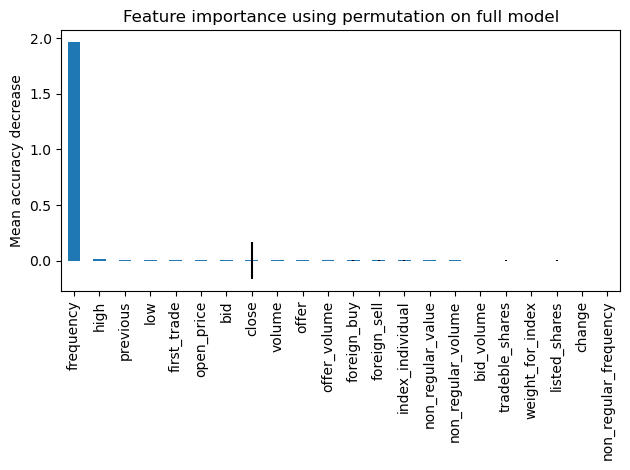

In [9]:
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

data_importance = pd.Series(result.importances_mean, index=['previous', 'open_price', 'first_trade', 'high', 'low', 'close',
       'change', 'frequency', 'index_individual', 'offer', 'volume',
       'offer_volume', 'bid', 'bid_volume', 'listed_shares', 'tradeble_shares',
       'weight_for_index', 'foreign_sell', 'foreign_buy', 'non_regular_volume',
       'non_regular_value', 'non_regular_frequency'])

fig, ax = plt.subplots()
data_importance.sort_values(ascending=False).plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importance using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Train again

In [10]:
df.drop(columns=[ 'non_regular_volume', 'non_regular_value', 'non_regular_frequency','listed_shares', 'tradeble_shares',
                'weight_for_index', 'change', 'bid_volume', 'offer_volume', 'foreign_sell', 'foreign_buy'], inplace=True)

In [11]:
X = df.drop(columns=["value"])
y = df.value

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1412, 11), (354, 11), (1412,), (354,))

In [12]:
preprosessor = ColumnTransformer([
    ('numeric', num_pipe, ['previous', 'open_price', 'first_trade', 'high', 'low', 'close', 'frequency', 
                           'index_individual', 'offer', 'volume', 'bid']),
])

model = Pipeline([
    ('prep', preprosessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])


parameter = {
    'prep__numeric__poly__degree': [1, 2, 3],
    'prep__numeric__poly__interaction_only': [True, False]
}

model = GridSearchCV(model, parameter, n_jobs=-1, cv=2, verbose=1)
model.fit(X_train, y_train)
print(model.best_params_)
print(model.score(X_train,y_train), model.best_score_, model.score(X_test,y_test))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
{'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.994838459955293 0.9665454187371723 0.993099250984419


# Heap map

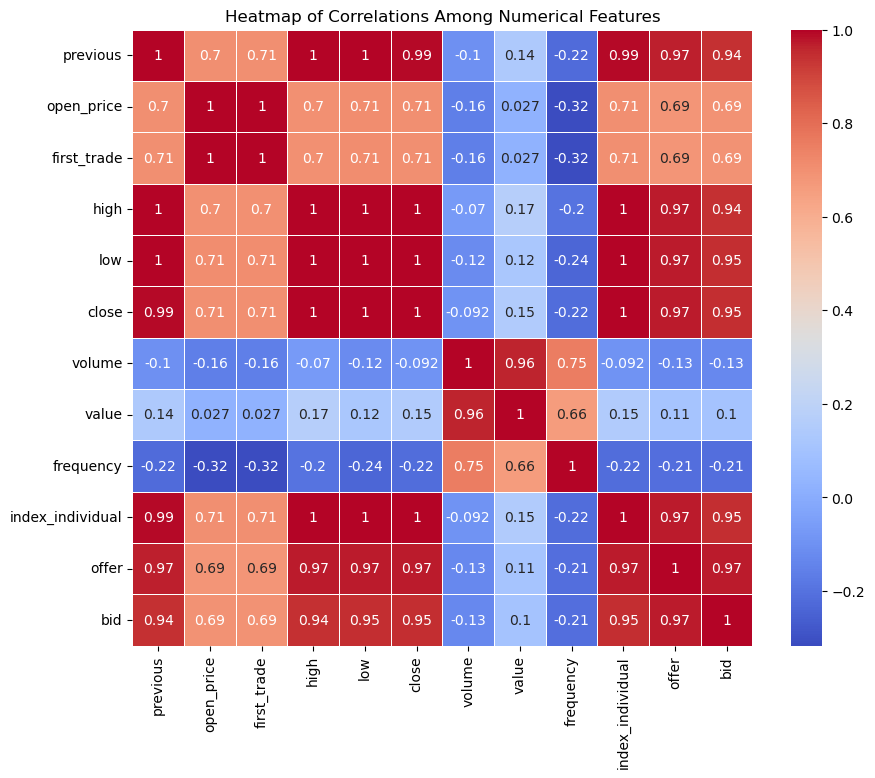

In [13]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Heatmap of Correlations Among Numerical Features')
plt.show()

In [14]:
X_train.head()

,previous,open_price,first_trade,high,low,close,volume,frequency,index_individual,offer,bid
1320,3110.0,0.0,0.0,3150.0,3060.0,3080.0,175767800.0,21348.0,1618.6,3080.0,3070.0
782,3820.0,3800.0,3810.0,3810.0,3640.0,3660.0,254154700.0,17701.0,1923.4,3660.0,3650.0
1128,4380.0,4430.0,4440.0,4450.0,4420.0,4450.0,95138200.0,4114.0,2338.6,4450.0,4440.0
199,2760.0,2790.0,2785.0,2825.0,2770.0,2805.0,74714100.0,4625.0,1474.1,2810.0,2805.0
704,4200.0,4200.0,4200.0,4270.0,4200.0,4250.0,62887900.0,5254.0,2233.5,4260.0,4250.0


# Save model

In [15]:
import pickle, os

os.makedirs("Models", exist_ok=True)

filename = "Models/bursa_RF.pkl"
pickle.dump(model.best_estimator_, open(filename, "wb"))

# Load model

In [16]:
loaded_model = pickle.load(open("Models/bursa_RF.pkl", 'rb'))

# Predict

In [18]:
X_pred = pd.DataFrame([[3000, 3700, 3550, 3790, 3675,2980 ,83651000, 4622, 2030, 3400, 3240]], columns=X_train.columns)
X_pred

,previous,open_price,first_trade,high,low,close,volume,frequency,index_individual,offer,bid
0,3000,3700,3550,3790,3675,2980,83651000,4622,2030,3400,3240


In [19]:
loaded_model.predict(X_pred)

array([2.96315124e+11])